In [ ]:
import sys

if 'emcee' not in sys.modules:
  !pip install emcee

In [ ]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import emcee

## Introduction

Probabilistic programming's goal is facilitate the problem of statistical modeling. It is not about designing random algorithms which is part of Computer Science, not Statistics.

<br><center><img src='https://raw.githubusercontent.com/jpneto/topicsInPython/main/imgs/probabilistic_programming.tensorflow.png' width=600px><br>image from TensorFlow website</center>




In Computer Science, for a given problem, we write an appropriate program with certain parameters to output values wrt the given parameter values. Probability has a similar workflow, where the  program/algorithm is replaced by a probabilistic model.

In Statistics, again for a given problem, it is the 'output' (the observations) $y$ that is given, not its parameters $x$. The (Bayesian) statistician must create an appropriate probabilistic  model $p(x,y)$ that can be fitted to provide conditional distributions over the unknown parameters given the known observations, $p(x|y)$. 

In probabilistic programming these statistical models are specified by a set of random variables and their distributions which then can be automatically executed by the computer. These models can be described in a declarative fashion (like in BUGS and JAGS), in an imperative fashion (like in emcee) or in a mix of both (like in Stan and PyMC3).

### Example - Inferring the rate of a binary process

Given a binary process with observed $k$ successes from $n$ trials what is the success rate $\theta$?

Using the probabilistic programming approach, we wish to know the conditional distribution $p(\theta~|~k,n)$ for parameter $\theta$, given observations $k$ and $n$.

Bayes theorem states that:

$$p(\theta~|~k,n) = \frac{p(k,n,\theta)}{p(k,n)} = \frac{p(k,n~|~\theta)~p(\theta)}{p(k,n)}$$

and since $p(k,n)$, for fix values of $k,n$, is a constant 

$$p(\theta~|~k,n) \propto p(k,n~|~\theta)~p(\theta)$$

Because of numerical reasons, it's better to work with log values,

$$\underbrace{\log p(\theta~|~k,n)}_{\text{log posterior}} \propto \underbrace{\log p(k,n~|~\theta)}_{\text{log likelihood}} + \underbrace{\log p(\theta)}_{\text{log prior}}$$

This mathematical reasoning is exactly the same for all models. The only variables are (a) the set of observations and their observed values, (b) the set of parameters.

From the perspective of the model, the observations and the parameters are of the same nature, they are all **random variables**. The only thing that separates them is that observations are **observed variables** and the parameters are **unobserved variables**.

What the model requires from the programmer is to specify what are the distributions these random variables follow (and how they related to each other).




In our example, we need to choose appropriate distributions to relate our variables:

We pick the binomial distribution for $k$ since this is a classical distribution for counting discrete outcomes. Since $\theta$ represents a probability, it must be associated with a distribution with domain $[0,1]$. Again, the classical choice is the Beta distribution. A $\text{Beta}(1,1)$ assigns the same probability density for all values in $[0,1]$.

These associations can be described with the standard notation, $x \sim d$, i.e., random variable $x$ follows distribution $d$:

$$k \sim \text{Binomial}(n, \theta)$$

$$\theta \sim \text{Beta}(1,1)$$

That's it! _This is the probabilistic model for the problem_.

We now need a computational tool to execute the model.

In Python there are several alternatives for probabilistic programming. Here we present the simpler solution, module `emcee`, aka the MC[MC Hammer](https://www.google.com/search?q=MC%20Hammer&tbm=isch&tbs=isz:l&client=firefox-b-d&hl=en&sa=X&ved=0CAEQpwVqFwoTCJCropmkp-wCFQAAAAAdAAAAABAC&biw=1133&bih=868).

## The MCMC Hammer

`emcee` is a Python module for sampling from statistical models like the one we just wrote.

The user needs to define a function that returns a value proportional to the log posterior probability $\log p(\text{parameters}~|~\text{observations})$. 

`emcee` is able to return samples from that posterior. These samples are then used to build an empirical distribution that approximates the posterior distribution associated with the unknown model parameters.

Here's the implementation of the log posterior as the sum of the log prior and log likelihood:

In [ ]:
# params is a list of parameters. Herein, it just has one value: theta
def log_prior(params):
  theta = params[0]
  if theta<0 or theta>1: # if outside the domain [0,1], the density is zero
    return -np.inf # log(0) == -oo
  return ss.beta.logpdf(theta,1.0,1.0)

def log_likelihood(params, k, n):
  theta = params[0]
  res = ss.binom.logpmf(k,n,theta)
  if res == 0:
    return -np.inf
  return res

def log_posterior(params, k, n):
  lp = log_prior(params)
  if not np.isfinite(lp):
    return -np.inf
  return log_prior(params) + log_likelihood(params, k, n)

Say that we had 60 successes from 90 trials:

In [ ]:
# The observations: k successes from n trials
k = 60
n = 90

Let's run the model using `emcee`:

In [ ]:
# As stated, this problem has one parameter
# We will solve it with 3 parallel threads, each one called a walker
nparams, nwalkers = 1, 3

sampler = emcee.EnsembleSampler(nwalkers, nparams, log_posterior, args=[k,n])

nburn  = 1000
nsteps = 5000
# Start the walkers around [0.4,0.6].
p0 = 0.4 + 0.2*np.random.random((nwalkers, nparams))
sampler.run_mcmc(p0, nsteps);

The model was executed and fitted with the observations. 

We can extract the samples produced and visualize them:


        Posterior estimation for parameter θ given observations k,n:
        θ = 0.664 +/- 0.048

        Conditional distribution of parameter θ given the observations:
        


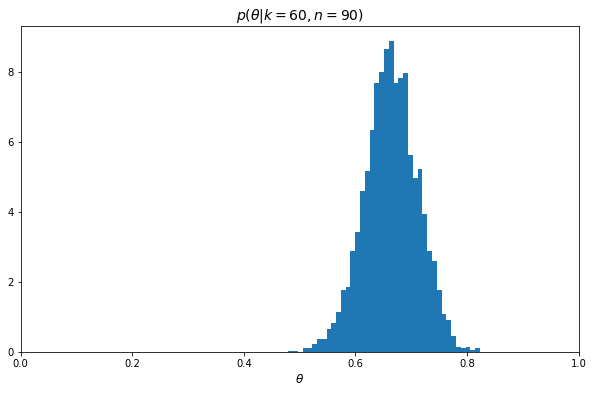

In [ ]:
# sampler.chain is of shape (nwalkers, nsteps, nparams)
# remove burnin samples and reshape into a list
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, nparams).T

def report(trace, k, n):
  print("""
        Posterior estimation for parameter θ given observations k,n:
        θ = {0:4.3f} +/- {1:4.3f}

        Conditional distribution of parameter θ given the observations:
        """.format(np.mean(trace), np.std(trace)))

  fig, ax = plt.subplots(figsize=(10,6))
  ax.set_title(r'$p(\theta | k={0},n={1})$'.format(k,n), fontsize=14)
  ax.set_xlabel(r'$\theta$', fontsize=12)
  ax.set_xlim([0,1])
  ax.hist(trace[0], bins=40, density=True);

report(emcee_trace, k, n) 

What if, instead of $k=60,n=90$, we had $k=6,n=9$?

For `emcee` this is no trouble at all:


        Posterior estimation for parameter θ given observations k,n:
        θ = 0.641 +/- 0.138

        Conditional distribution of parameter θ given the observations:
        


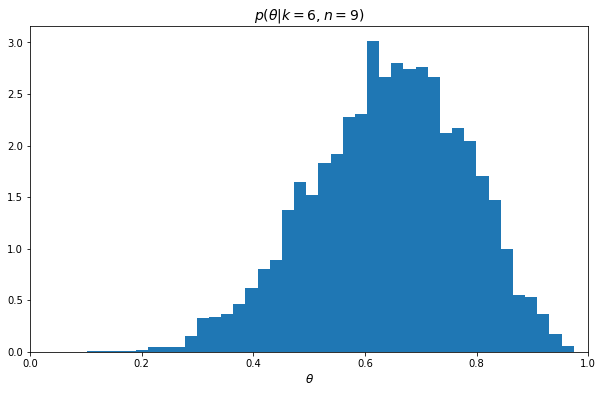

In [ ]:
k = 6 # just give the new values to the model
n = 9

sampler = emcee.EnsembleSampler(nwalkers, nparams, log_posterior, args=[k,n])
sampler.run_mcmc(p0, nsteps)
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, nparams).T

report(emcee_trace, k, n)

This second result expresses more uncertainty (the conditional distribution is wider). This makes sense. If we only perform 9 trials, it is to be expected that we will know less about the system under study, than if we perform 90 trials.



---



As a sidenote, using mainstream statistics, the maximum likelihood estimation for $\theta$ would be the same, ie, $\hat{\theta} = 60/90 = 6/9 = 2/3$. 

To find a confidence interval for both problem instances read [this webpage](https://en.wikipedia.org/wiki/Binomial_distribution#Confidence_intervals) or this [article](http://citeseerx.ist.psu.edu/viewdoc/summary;jsessionid=BF0333B82FD5B5A73FD66C40CA464E37?doi=10.1.1.326.1772) presenting seven (!) different methods (good luck). Using R's `Hmisc::binconf`, a black-box function, the 95% confidence intervals for $k=60,n=90$ and $k=6,n=9$ are, respectively, $[0.56,0.76]$ and $[0.35, 0.87]$ both expressing less uncertainty (ie, they are smaller) than the previous probabilistic results. This might seem as an advantage but [it is not](https://stats.stackexchange.com/questions/2272).



---



To continue reading about this subject using Python check [An Introduction to Probability and Computational Bayesian Statistics](https://ericmjl.github.io/essays-on-data-science/machine-learning/computational-bayesian-stats/) and the [Probabilistic Programming & Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/).



---



## References

+ Dan Foreman-Mackey et al., [emcee User Manual](https://emcee.readthedocs.io/en/stable/) (2019)

+ Jake VanderPlas, [Frequentism and Bayesianism: A Practical Introduction](https://jakevdp.github.io/tag/bayesianism.html) (2014, 2015)

+ Chris Burns, [emcee Tutorial](https://users.obs.carnegiescience.edu/cburns/ipynbs/Emcee.html) (2014)

